# Class

In [33]:
import os
import cv2
import csv
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

class CellAnimationGenerator:
    def __init__(self):
        self.background_images = []
        self.cell_images = []

    def load_assets(self, bg_folder, cell_folder):
        def load_img_folder(folder):
            return [cv2.imread(os.path.join(folder, f))
                    for f in os.listdir(folder)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        self.background_images = load_img_folder(bg_folder)
        self.cell_images = load_img_folder(cell_folder)

        if not self.background_images or not self.cell_images:
            raise ValueError("Missing image assets!")

    def create_composite_background(self, size=(450, 450)):
        composite = np.zeros((*size, 3), dtype=np.uint8)
        tile_size = size[0] // 3
        for i in range(0, size[0], tile_size):
            for j in range(0, size[1], tile_size):
                tile = random.choice(self.background_images)
                tile = cv2.resize(tile, (tile_size, tile_size))
                composite[i:i+tile_size, j:j+tile_size] = tile
        return composite

    def render_cell(self, canvas, cell_img, position, blur_radius=51):
        x, y = position
        h, w = canvas.shape[:2]
        ch, cw = cell_img.shape[:2]

        x1, x2 = max(0, x), min(w, x + cw)
        y1, y2 = max(0, y), min(h, y + ch)
        cx1, cx2 = max(0, -x), cw - max(0, x + cw - w)
        cy1, cy2 = max(0, -y), ch - max(0, y + ch - h)

        mask = np.zeros((cy2 - cy1, cx2 - cx1), dtype=np.float32)
        center = ((cx2 - cx1) // 2, (cy2 - cy1) // 2)
        radius = min(center)
        cv2.circle(mask, center, radius, 1, -1)
        mask = cv2.GaussianBlur(mask, (blur_radius, blur_radius), 0)[..., None]

        canvas[y1:y2, x1:x2] = (
            canvas[y1:y2, x1:x2] * (1 - mask) +
            cell_img[cy1:cy2, cx1:cx2] * mask
        ).astype(np.uint8)

        return canvas

class CellMotionSimulator:
    def __init__(self, canvas_size):
        self.width, self.height = canvas_size
        self.x = random.randint(-60, -10)
        self.y = random.randint(0, self.height)
        self.origin_y = self.y

        # self.velocity = random.uniform(8, 12)
        self.velocity = random.uniform(30, 47)  # было: 8–12
        self.amplitude = random.uniform(10, 30)
        self.wave_freq = random.uniform(0.03, 0.08)
        self.noise_phase = random.uniform(0, math.pi * 2)
        self.noise_amp = random.uniform(1, 3)
        self.noise_freq = random.uniform(0.5, 2.0)

    def update_position(self, delta_time):
        self.x += self.velocity * delta_time
        self.noise_phase += self.noise_freq * delta_time

        wave = self.amplitude * math.sin(self.wave_freq * self.x)
        noise = math.sin(self.noise_phase) * self.noise_amp
        self.y = self.origin_y + wave + noise

        return self.x < self.width + 100

def generate_animation_with_tracking(bg_folder, cell_folder, output_dir,
                                     output_file="cell_animation.mp4",
                                     csv_file="trajectories.csv",
                                     traj_vis_file="trajectories_visualization.png",
                                     duration=10, fps=24):

    os.makedirs(output_dir, exist_ok=True)

    generator = CellAnimationGenerator()
    generator.load_assets(bg_folder, cell_folder)

    canvas_size = (450, 450)
    background = generator.create_composite_background(canvas_size)
    total_frames = duration * fps

    video_writer = cv2.VideoWriter(os.path.join(output_dir, output_file),
                                   cv2.VideoWriter_fourcc(*'mp4v'), fps, canvas_size)

    trajectories = {}
    colors = {}

    active_cells = []
    with open(os.path.join(output_dir, csv_file), 'w', newline='') as f_csv:
        writer = csv.writer(f_csv)
        writer.writerow(['frame', 'time', 'cell_id', 'x', 'y'])

        for _ in range(8):  # сразу 8 клеток в самом начале
            cell_img = random.choice(generator.cell_images)
            size = random.randint(40, 80)
            cell_id = len(trajectories)
            active_cells.append({
                'id': cell_id,
                'simulator': CellMotionSimulator(canvas_size),
                'image': cv2.resize(cell_img, (size, size))
            })
            trajectories[cell_id] = []
            colors[cell_id] = tuple(np.random.randint(0, 255, 3).tolist())

        for frame_idx in tqdm(range(total_frames), desc="Generating animation"):
            current_time = frame_idx / fps
            frame = background.copy()

            if len(active_cells) < 8 and (frame_idx % 20 == 0 or len(active_cells) < 2):
                cell_img = random.choice(generator.cell_images)
                size = random.randint(40, 80)
                cell_id = len(trajectories)
                active_cells.append({
                    'id': cell_id,
                    'simulator': CellMotionSimulator(canvas_size),
                    'image': cv2.resize(cell_img, (size, size))
                })
                trajectories[cell_id] = []
                colors[cell_id] = tuple(np.random.randint(0, 255, 3).tolist())

            for cell in active_cells[:]:
                sim = cell['simulator']
                alive = sim.update_position(1 / fps)

                x, y = int(sim.x), int(sim.y)
                if not alive:
                    active_cells.remove(cell)
                    continue

                trajectories[cell['id']].append((x, y))
                writer.writerow([frame_idx, round(current_time, 2), cell['id'], x, y])
                frame = generator.render_cell(frame, cell['image'], (x, y))

            video_writer.write(frame)

    video_writer.release()
    print(f"Video saved to {output_file}")
    visualize_trajectories(background, trajectories, colors,
                           os.path.join(output_dir, traj_vis_file))

def visualize_trajectories(background, trajectories, colors, save_path):
    image = background.copy()
    for cell_id, points in trajectories.items():
        if len(points) < 2:
            continue
        pts = np.array(points, dtype=np.int32)
        cv2.polylines(image, [pts], False, colors[cell_id], 2)
        cv2.circle(image, pts[0], 5, colors[cell_id], -1)
        cv2.circle(image, pts[-1], 5, colors[cell_id], -1)

    cv2.imwrite(save_path, image)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Cell Trajectories")
    plt.axis("off")
    plt.show()

# Run

Generating animation: 100%|██████████| 240/240 [00:00<00:00, 868.20it/s]


Video saved to cell_animation.mp4


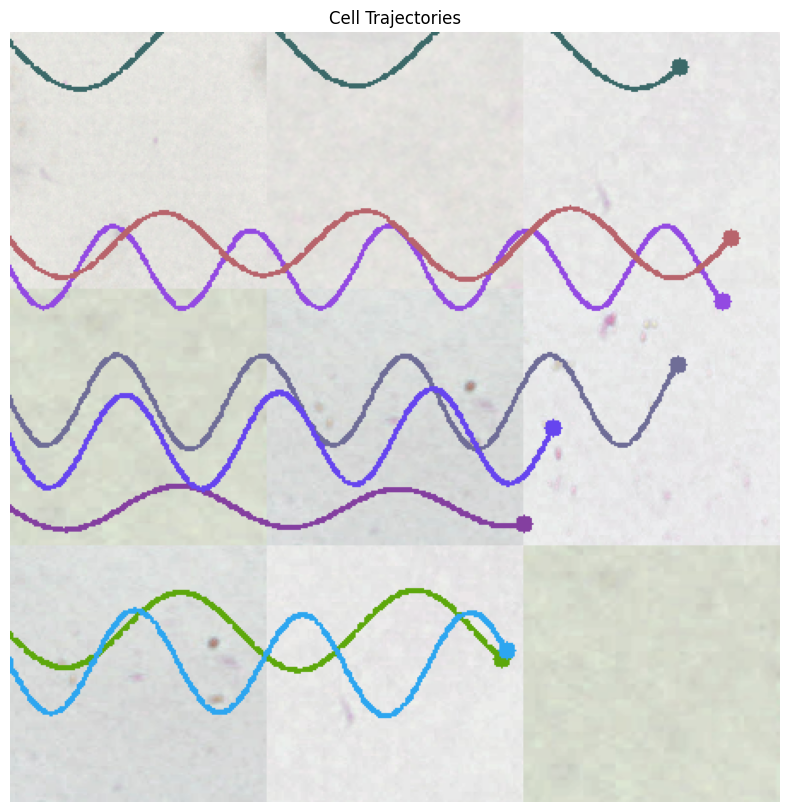

In [36]:
generate_animation_with_tracking(
    bg_folder="/Users/nident/Desktop/RSREU/МФТИ/2семак/blood_cells_dataset/fon",
    cell_folder="/Users/nident/Desktop/RSREU/МФТИ/2семак/blood_cells_dataset/patch",
    output_dir="/Users/nident/Desktop/RSREU/МФТИ/2семак/"
)